# CS445: Computational Photography
## FIANL PROJECT


## Recovering HDR Radiance Maps 

Load libraries and data

In [2]:
# jupyter extension that allows reloading functions from imports without clearing kernel :D
%load_ext autoreload
%autoreload 2

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# System imports
import os
from os import path
import math

# Third-Party Imports
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

%matplotlib inline
from random import random
import time
import scipy
import scipy.sparse.linalg

from IPython.display import HTML
from IPython.display import Video
import shutil

# modify to where you store your project data including utils
datadir = "C:/Users/chaob/Desktop/445/finalproject/fp/FinalProject" 

utilfn = datadir + "utils"
# !cp -r "$utilfn" .
samplesfn = datadir + "samples"
# !cp -r "$samplesfn" .

# can change this to your output directory of choice
# !mkdir "images"
# !mkdir "images/outputs"

# import starter code
import utils
from utils.io import read_image, write_image, read_hdr_image, write_hdr_image
from utils.display import display_images_linear_rescale, rescale_images_linear
from utils.hdr_helpers import gsolve
from utils.hdr_helpers import get_equirectangular_image
from utils.bilateral_filter import bilateral_filter
from utils.bilateral_filter import bilateral_filter




Bad key text.latex.preview in file /Users/shiqiliu/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.7.2/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /Users/shiqiliu/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.7.2/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /Users/shiqiliu/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       

### Reading Videos



In [5]:
def import_video(video_path):

    # Create a directory to store the extracted frames
    output_folder = 'frames'+ '/' + vname
    
    # Check if the directory exists
    if os.path.exists(output_folder):
        # If it exists, remove the directory and its contents
        shutil.rmtree(output_folder)
    os.makedirs(output_folder, exist_ok=True)

    # Open the video file
    video = cv2.VideoCapture(video_path)

    # Get the video properties
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(video.get(cv2.CAP_PROP_FPS))
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

    # Initialize variables
    frame_count = 0
    frames = []

    # Read frames from the video
    while True:
        ret, frame = video.read()
        if not ret:
            break

        # Save the frame as an image in the output folder
        frame_path = os.path.join(output_folder, f"frame_{frame_count:04d}.jpg")
        cv2.imwrite(frame_path, frame)

        # Append the frame to the list
        frames.append(frame)

        frame_count += 1

    # Release the video object
    video.release()

    print(f"Total frames: {total_frames}")
    print(f"Frames extracted: {frame_count}")
    print(f"Frames saved in the folder: {output_folder}")

    return frames, width, height, fps


In [6]:
imdir = 'samples'
vname = 'cat1'

# Specify the path to the video file
video_path = imdir + '/' + vname +'.mp4'

# Import the video and get the frames and video properties
frames, width, height, fps = import_video(video_path)

[ WARN:0@2.349] global /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_11nitadzeg/croot/opencv-suite_1691620374638/work/modules/videoio/src/cap_gstreamer.cpp (2386) handleMessage OpenCV | GStreamer warning: your GStreamer installation is missing a required plugin
[ WARN:0@2.349] global /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_11nitadzeg/croot/opencv-suite_1691620374638/work/modules/videoio/src/cap_gstreamer.cpp (2402) handleMessage OpenCV | GStreamer warning: Embedded video playback halted; module uridecodebin0 reported: Your GStreamer installation is missing a plug-in.
[ WARN:0@2.349] global /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_11nitadzeg/croot/opencv-suite_1691620374638/work/modules/videoio/src/cap_gstreamer.cpp (1356) open OpenCV | GStreamer warning: unable to start pipeline
[ WARN:0@2.349] global /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_11nitadzeg/croot/opencv-suite_1691620374638/work/modules/videoio/src/c

Total frames: 145
Frames extracted: 144
Frames saved in the folder: frames/cat1


In [7]:
# Display the video in the notebook
video = Video(video_path)
print(video_path)
display(video)

samples/cat1.mp4


In [8]:
# First frame is background, or can be frames[0]
background_image_file = 'frames'+ '/' + vname + '/' +'frame_0000.jpg'
background_image = read_image(background_image_file)

# background_image_file = imdir + '/' + 'empty.jpg'
# background_image = read_image(background_image_file)

### Background removal

Compute the HDR image as average of irradiance estimates from LDR images

In [9]:
def background_subtraction_o(frames, width, height, fps, vname):
    # Create directories to store the output frames and video
    output_folder_bs = "background_removed_frames_o" + '/' + vname
    
    # Check if the directory exists
    if os.path.exists(output_folder_bs):
        # If it exists, remove the directory and its contents
        shutil.rmtree(output_folder_bs)
    os.makedirs(output_folder_bs, exist_ok=True)
    
    # Read the first frame as the background image
    background = cv2.cvtColor(frames[0], cv2.COLOR_BGR2GRAY)
    
    # Apply blurring to the background frame
    blurred_background = cv2.GaussianBlur(background, (15, 15), 0)
    
    # Initialize variables
    processed_frames = []
    
    # Create a kernel for morphological operations
    kernel = np.ones((200, 200), np.uint8)
    
    # Process frames for background subtraction
    for i, frame in enumerate(frames):
        # Convert the frame to grayscale
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # Apply blurring to the grayscale frame
        blurred_frame = cv2.GaussianBlur(gray_frame, (15, 15), 0)
        
        # Perform background subtraction
        diff = cv2.absdiff(blurred_background, blurred_frame)
        
        # Apply thresholding
        threshold = 60
        _, thresh = cv2.threshold(diff, threshold, 255, cv2.THRESH_BINARY)
        
        # Apply erosion
        eroded = cv2.erode(thresh, kernel, iterations=10)
        
        # # Apply dilation
        dilated = cv2.dilate(eroded, kernel, iterations=3)
        
        # Save the thresholded frame as an image in the output folder
        frame_path_bs = os.path.join(output_folder_bs, f"frame_{i:04d}.jpg")
        cv2.imwrite(frame_path_bs, thresh)
        
        # Append the processed frame to the list
        processed_frames.append(thresh)
    
    print(f"Background subtraction completed.")
    print(f"Output frames saved in the folder: {output_folder_bs}")
    
    return processed_frames, output_folder_bs

In [10]:
# Perform background subtraction on the frames and get the processed frames
processed_frames_o, output_folder_bs_o = background_subtraction_o(frames, width, height, fps, vname)

Background subtraction completed.
Output frames saved in the folder: background_removed_frames_o/cat1


In [11]:
%%capture
!ffmpeg -framerate 30 -i "{output_folder_bs_o}/frame_%04d.jpg" -c:v libx264 -pix_fmt yuv420p "{output_folder_bs_o}/bs_video.mp4"

In [12]:
#会占用导致无法更改，最后展示用
# # Display the video in the notebook
# v="background_removed_frames/cat1/bs_video.mp4"
# video = Video(v)
# display(video)

In [13]:
def background_subtraction_improve(frames, width, height, fps, vname):
    # Create directories to store the output frames and video
    output_folder_bs = "background_removed_frames_improve" + '/' + vname
    
    # Check if the directory exists
    if os.path.exists(output_folder_bs):
        # If it exists, remove the directory and its contents
        shutil.rmtree(output_folder_bs)
    os.makedirs(output_folder_bs, exist_ok=True)
        
    # Initialize variables
    processed_frames = []
    
    # Create a kernel for morphological operations
    kernel = np.ones((80, 80), np.uint8)
    
    # Create a GMM-based background subtractor
    background_subtractor = cv2.createBackgroundSubtractorKNN(detectShadows=True)
    
    # Define the number of initial frames to skip or use for training
    num_initial_frames = 5

    # Train the background subtractor on initial frames
    for i in range(num_initial_frames):
        frame = frames[i]
        blurred_frame = cv2.GaussianBlur(frame, (35, 35), 0)
        _ = background_subtractor.apply(blurred_frame)

    # Process frames for background subtraction
    for i, frame in enumerate(frames):
        
        blurred_frame = cv2.GaussianBlur(frame, (35, 35), 0)
        # Apply background subtraction
        mask = background_subtractor.apply(blurred_frame)

        # Apply thresholding to the mask
        _, thresh = cv2.threshold(mask, 250, 255, cv2.THRESH_BINARY)
    
       
        # Apply erosion
        eroded = cv2.erode(thresh, kernel, iterations=2)
        
        # # Apply dilation
        dilated = cv2.dilate(eroded, kernel, iterations=10)
        
        # Save the thresholded frame as an image in the output folder
        frame_path_bs = os.path.join(output_folder_bs, f"frame_{i:04d}.jpg")
        cv2.imwrite(frame_path_bs, thresh)
        
        # Append the processed frame to the list
        processed_frames.append(thresh)
    
    print(f"Background subtraction completed.")
    print(f"Output frames saved in the folder: {output_folder_bs}")
    
    return processed_frames, output_folder_bs

In [14]:
# Perform background subtraction on the frames and get the processed frames
processed_frames_improve, output_folder_bs_improve = background_subtraction_improve(frames, width, height, fps, vname)

Background subtraction completed.
Output frames saved in the folder: background_removed_frames_improve/cat1


In [15]:
%%capture
!ffmpeg -framerate 30 -i "{output_folder_bs_improve}/frame_%04d.jpg" -c:v libx264 -pix_fmt yuv420p "{output_folder_bs_improve}/bs_video.mp4"

In [16]:
def filter_white_regions(image_path):
    # Read the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Find contours in the binary image
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Check if any contours were found
    if len(contours) > 0:
        # Find the area of the largest contour
        largest_area = max(cv2.contourArea(contour) for contour in contours)
        
        # Set the area threshold to be the area of the largest contour minus 200
        area_threshold = largest_area - 0.05*largest_area
        
        # Create a mask to store the filtered white regions
        mask = np.zeros_like(image)
        
        # Iterate over each contour
        for contour in contours:
            # Calculate the area of the contour
            area = cv2.contourArea(contour)
            
            # If the area is greater than or equal to the threshold, draw the contour on the mask
            if area > 2000 and area >= area_threshold:
                cv2.drawContours(mask, [contour], 0, 255, -1)
        
        # Apply the mask to the original image
        result = cv2.bitwise_and(image, image, mask=mask)
    else:
        # If no contours were found, return the original image
        result = image
    
    return result

In [17]:

# Specify the folder path containing the black and white images
folder_path = output_folder_bs_improve

# Create a new folder to store the processed images
out_folder = "obj_frames_improve" + '/' + vname
# Check if the directory exists
if os.path.exists(out_folder):
    # If it exists, remove the directory and its contents
    shutil.rmtree(out_folder)
os.makedirs(out_folder, exist_ok=True)


# Iterate over each image file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".jpg") :  # Adjust the file extensions as needed
        image_path = os.path.join(folder_path, filename)
        
        # Process the image to keep the white regions with areas greater than or equal to the threshold
        processed_image = filter_white_regions(image_path)
        
        # Save the processed image to the output folder
        output_path = os.path.join(out_folder, filename)
        cv2.imwrite(output_path, processed_image)

In [18]:
%%capture
!ffmpeg -framerate 30 -i "{out_folder}/frame_%04d.jpg" -c:v libx264 -pix_fmt yuv420p "{out_folder}/obj_video.mp4"

### Tour into image

Using a Spidery Mesh Interface to Make Animation from a Single Image

## 2D to 3D 
​
Building a 3D mobdel from 2D-image 

In [1]:
#prepare the enviornment -- check the requirenments file
#image processing

#library import
import matplotlib 
#matplotlib.use('TkAgg')
from matplotlib import pyplot as plt
#from PIL import Image
import PIL.Image
import torch
from transformers import GLPNImageProcessor, GLPNForDepthEstimation
from IPython.display import Image, display



Bad key text.latex.preview in file /Users/shiqiliu/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.7.2/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /Users/shiqiliu/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.7.2/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /Users/shiqiliu/anaconda3/lib/python3.11/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       

In [2]:
#Getting model
feature_extractor = GLPNImageProcessor.from_pretrained("vinvino02/glpn-nyu")
model = GLPNForDepthEstimation.from_pretrained("vinvino02/glpn-nyu")


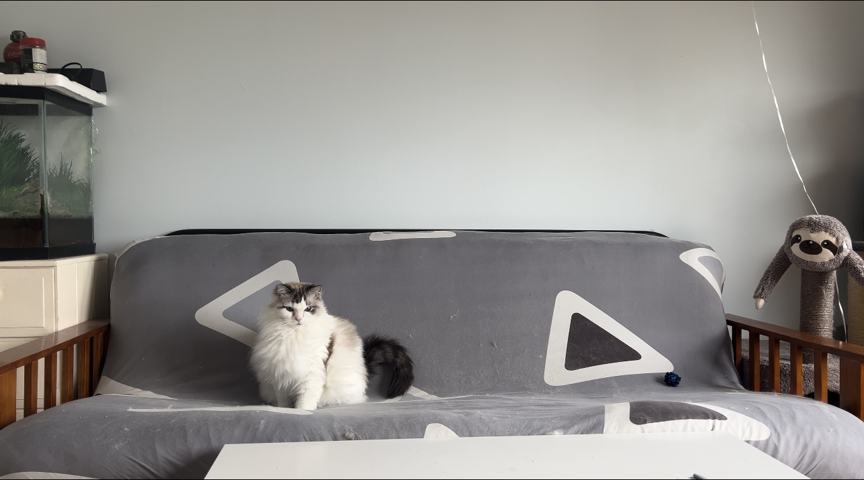

In [3]:
#Loading and resizing the image
image = PIL.Image.open("samples/2d_image.jpg")
new_height = 480 if image.height > 480 else image.height
new_height -= (new_height % 32)
new_width = int(new_height * image.width / image.height)
diff = new_width % 32

#resize
new_width = new_width - diff if diff < 16 else new_width + 32 - diff
new_size = (new_width, new_height)
image = image.resize(new_size)

#show the image
display(image)

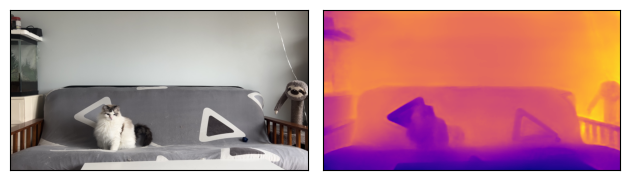

In [4]:
#prepare the image for the model
inputs = feature_extractor(images=image, return_tensors="pt")

#Get the prediction from the model
with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

#post-processing
pad = 16
output = predicted_depth.squeeze().cpu().numpy()*1000.0
output = output[pad:-pad, pad:-pad]
image = image.crop((pad,pad,image.width - pad, image.height - pad))

#visualize the prediction
fig, ax = plt.subplots(1,2)
ax[0].imshow(image)
ax[0].tick_params(left=False, bottom = False, labelleft=False, labelbottom=False)
ax[1].imshow(output,cmap='plasma')
ax[1].tick_params(left=False, bottom = False, labelleft=False, labelbottom=False)
plt.tight_layout()
plt.pause(5)


In [5]:
#import the libaries
import numpy as np
import open3d as o3d

#prepare the depth image for open3d
width, height = image.size
depth_image = (output * 255 / np.max(output)).astype(np.uint8)
image = np.array(image)


In [6]:
#create rgbd image
depth_o3d = o3d.geometry.Image(depth_image)
image_o3d = o3d.geometry.Image(image)
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(image_o3d,depth_o3d,convert_rgb_to_intensity=False)

In [7]:
#create the camera
camera_intrinsic = o3d.camera.PinholeCameraIntrinsic()
camera_intrinsic.set_intrinsics(width,height,500,500,width/2,height/2)

#create o3d point cloud
pcd_raw = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, camera_intrinsic)
#o3d.visualization.draw_geometries([pcd_raw])
#display((pcd)).to_html5_video()

#post-processing the 3D point cloud

#outline removal
cl,ind = pcd_raw.remove_statistical_outlier(nb_neighbors=20, std_ratio=6.0)
pcd = pcd_raw.select_by_index(ind)

#estimate normals
pcd.estimate_normals()
pcd.orient_normals_to_align_with_direction()

#surface reconstruction

mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=10,n_threads=1)[0]

#rotate the mesh
rotation = mesh.get_rotation_matrix_from_xyz((np.pi,0,0))
mesh.rotate(rotation,center=(0,0,0))

#if want to change color
#mesh_uniform = mesh.paint_uniform_color([0.9,0.8,0.9])
#mesh_uniform.compute_vertex_normals()

#3D Mesh Export
o3d.io.write_triangle_mesh("outputs/3dObject.obj",mesh)


True

In [8]:
#visualize the mesh, make the mesh show front
o3d.visualization.draw_geometries([mesh], mesh_show_back_face=True)

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


In [12]:
#display it
#! pip install obj2html
#from obj2html import obj2html
#from IPython.display import display, HTML
#obj2html('outputs/3DObject.obj', 'index.html')
#display(HTML('index.html'))